<a href="https://colab.research.google.com/github/LCaravaggio/politext/blob/main/Toda_la_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
from collections import Counter
import ast

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Se lee la base original
base=pd.read_csv('/content/drive/MyDrive/par_esp_interventions_l1_l13.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
# Se conservan solamente las intervenciones de los partidos PSOE y PP
base=base[(base['party'] == 'PSOE') | (base['party'] == 'PP')]

In [92]:
# Faltan años en la base (2001, 2002, 2003) y PP aparece desde 1986 cuando se fundó en 1989
a=pd.DatetimeIndex(base.fecha).year.unique().tolist()
a.sort()
for x in a: 
  print(f"{x}: {base[pd.DatetimeIndex(base.fecha).year==x].party.unique()}")

1979: ['PSOE']
1980: ['PSOE']
1981: ['PSOE']
1982: ['PSOE']
1983: ['PSOE']
1984: ['PSOE']
1985: ['PSOE']
1986: ['PSOE' 'PP']
1987: ['PSOE' 'PP']
1988: ['PSOE' 'PP']
1989: ['PSOE' 'PP']
1990: ['PSOE' 'PP']
1991: ['PSOE' 'PP']
1992: ['PSOE' 'PP']
1993: ['PSOE' 'PP']
1994: ['PSOE' 'PP']
1995: ['PSOE' 'PP']
1996: ['PSOE' 'PP']
1997: ['PP' 'PSOE']
1998: ['PP' 'PSOE']
1999: ['PP' 'PSOE']
2000: ['PP' 'PSOE']
2004: ['PSOE' 'PP']
2005: ['PSOE' 'PP']
2006: ['PSOE' 'PP']
2007: ['PSOE' 'PP']
2008: ['PSOE' 'PP']
2009: ['PSOE' 'PP']
2010: ['PSOE' 'PP']
2011: ['PSOE' 'PP']
2012: ['PP' 'PSOE']
2013: ['PP' 'PSOE']
2014: ['PP' 'PSOE']
2015: ['PP' 'PSOE']
2016: ['PP' 'PSOE']
2017: ['PP' 'PSOE']
2018: ['PP' 'PSOE']
2019: ['PP' 'PSOE']


In [27]:
# Elimino de la base las intervenciones del Presidente de la cámara
base=base[(base['role'] != 'PRESIDENTE, PRESIDENTA') | (base['role'] != 'PRESIDENTE DEL CONGRESO DE LOS DIPUTADOS')]

In [28]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=stopwords.words('spanish')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [29]:
# Se incorporan las stopwords sugeridas por Federico
stopwords.extend(['señor', 'señora', 'mucha', 'gracia', 'año', 'pasado', 'cada', 'vez', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis' ,'siete', 'ocho', 'nueve', 'diez'])
stopwords.extend(['hoy', 'aquí', 'primer', 'lugar', 'primera', 'segunda', 'primero', 'segundo', 'siguiente', 'tercer'])
stopwords.extend(['convergencia', 'esquerra', 'republicana', 'grupo', 'parlamentaria', 'parlamentario', 'partido'])
stopwords.extend(['enmienda', 'votación', 'favor', 'abstención', 'ley', 'real', 'decreto', 'decretoley', 'resultado', 'voto', 'sé' ,'sí', 'silencio' ,'favor'])
stopwords.extend(['usted', 'señoría', 'presidente', 'presidenta', 'ministro', 'orden' , 'día', 'palabra', 'petición', 'posición', 'punto', 'vista', 'sesión', 'baldoví', 'duran', 'turno'])
stopwords.extend(['hacer', 'frente', 'puede' ,'ser', 'va', 'voy', 'decir'])
stopwords.extend(['millón', 'euro', 'emitido', 'efectuada', 'dio', 'comienzo', 'partido', 'queda', 'quedan', 'rechazada', 'aceptada', 'comienza', 'usted', 'sabe', 'abstención', 'diputado', 'gobierno'])
stopwords.extend(['continuación', 'votamos', 'telemático', 'republicanaizquierda', 'unidainiciativa', 'puede', 'bien', 'propuesta' ,'abstencion', 'mayoría', 'absoluta', 'pregunta', 'don', 'vamos', 'votar', 'llevar', 'cabo', 'millón', 'muchas', 'gracias'])

In [30]:
# Esta celda tarda unos 17 minutos en correr

base['tokens']=""
for ind in base.index:
    #elimino puntuación
    non_punctuation = base['intervention'][ind].translate(str.maketrans('', '', string.punctuation))
    word_tokens = word_tokenize(non_punctuation)

    #elimino stopwords
    tokens=[w for w in word_tokens if not w.lower() in stopwords]

    #stemming
    porter_stemmer = PorterStemmer()
    stemmers = [porter_stemmer.stem(word) for word in tokens]
    base['tokens'][ind] = [stem for stem in stemmers if stem.isalpha() and len(stem) > 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


# CV

In [31]:
from sklearn.model_selection import train_test_split
base['tokens']=base["tokens"].map(' '.join)
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)

In [32]:
# Balance de clase
y_train.value_counts()

PSOE    100658
PP       53320
Name: party, dtype: int64

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=[2,2], max_features=200, stop_words=stopwords, max_df=0.95, min_df=0.001)
vec = cv.fit(X_train['tokens'])

In [34]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

# LASSO

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

In [36]:
lr.fit(train_matrix,y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [37]:
predictions = lr.predict(test_matrix)

In [38]:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[ 3825,  1410],
       [22557, 48048]])

In [39]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          PP       0.14      0.73      0.24      5235
        PSOE       0.97      0.68      0.80     70605

    accuracy                           0.68     75840
   macro avg       0.56      0.71      0.52     75840
weighted avg       0.91      0.68      0.76     75840



In [40]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_[0]):
  features.append([vec.get_feature_names_out()[i],v ])

In [41]:
sorted(features, key = lambda x: x[1])

[['número formula', -4.737266657835918],
 ['feder izquierda', -2.5290668097397098],
 ['izquierda plural', -2.3424885436579355],
 ['portavoz socialista', -1.7296993292676017],
 ['vaya concluyendo', -1.72347355694031],
 ['congreso formula', -1.2442827138999684],
 ['diputada doña', -0.9540813761655207],
 ['fijación posicion', -0.7066765926955612],
 ['convergència unió', -0.6768119518198753],
 ['creación empleo', -0.6047970374502429],
 ['servicio social', -0.5668332449579576],
 ['comunidad económica', -0.4508605902645761],
 ['consecuencia interpelación', -0.4456184724518495],
 ['coalición canaria', -0.40110693916089696],
 ['tramitación proyecto', -0.34010962613175433],
 ['administracion pública', -0.3350891019837808],
 ['recuperación económica', -0.32561267766010976],
 ['gener poder', -0.31220119695270065],
 ['ciudadano español', -0.31044166773614473],
 ['diputación permanent', -0.3087229720589562],
 ['consideración proposición', -0.3041513469623868],
 ['izquierda unida', -0.29713260418157

In [42]:
# Entiendo que un número negativo en el coeficiente implica que el bigrama correlaciona bien con la clase 0, es decir PP. Por el otro lado, un coeficiente positivo implica que el bigrama correlaciona mejor con PSOE. 
lr.classes_

array(['PP', 'PSOE'], dtype=object)

In [43]:
# LASOO por año
from sklearn.metrics import f1_score

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

for x in range(1979,2019): 
  try: 
    base_year=base[pd.DatetimeIndex(base.fecha).year==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

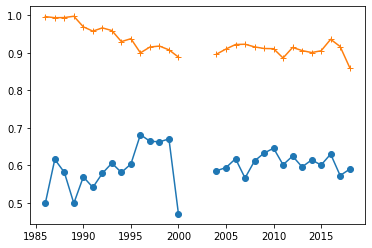

In [44]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(range(1979,2019), macro, marker='o')
plt.plot(range(1979,2019), weighted, marker='+')

In [45]:
# LASOO por legislatura
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']

for x in legislaturas: 
  try: 
    base_year=base[base.legislatura==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

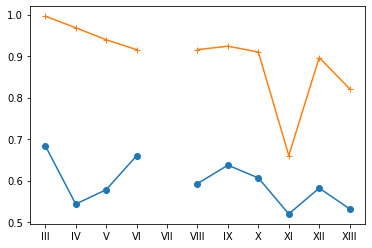

In [46]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.plot(legislaturas, weighted, marker='+')

# Regresión lineal

In [62]:
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)

In [63]:
vec = cv.fit(X_train['tokens'])

In [64]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

In [65]:
y_train.replace(['PSOE', 'PP'],[1, -1], inplace=True)
y_test.replace(['PSOE', 'PP'],[1, -1], inplace=True)

In [66]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [67]:
lr.fit(train_matrix,y_train)

LinearRegression()

In [68]:
predictions = lr.predict(test_matrix)

In [69]:
print(lr.coef_)

[ 1.42339897e-02 -8.38460224e-02  9.34137208e-02  5.97418843e-03
  2.29194117e-02  6.12946939e-02 -1.85130933e-02 -1.69101662e-02
  1.32656830e-02  1.45212349e-02 -9.11933998e-03  1.95194728e-01
  8.89306546e-02  4.74929645e-02  1.09383706e-02  8.35324681e-03
  4.15522870e-02 -5.25902205e-03  2.77088597e-01  9.97319596e-02
  3.15810647e-01 -1.06066574e-01 -1.55446370e-01  3.70666514e-01
  1.56456626e-02 -2.03287644e-03 -1.39552035e-01  3.21925928e-02
 -4.90707986e-01 -1.68002443e-01  3.59824069e-02  8.61211901e-02
 -1.12162483e-01 -6.63643959e-02 -2.48360396e-01 -2.90864142e-03
  1.15761995e-02 -1.50736606e-01  6.09766702e-03 -8.15751643e-02
 -3.18340754e-02 -2.99996883e-02  7.06066713e-02  4.38459925e-03
  6.76565576e-02  3.40424920e-02  1.67436839e-02 -3.20399170e-02
 -8.82053109e-03 -6.14993085e-02  1.72077223e-02  1.69116123e-02
  2.78054810e-01 -1.07772111e-01 -3.80301126e-01  3.08048767e-02
  1.84324767e-02  3.86769150e-02  1.43864956e-02  6.31642075e-02
  2.67073111e-02  8.58747

In [70]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [71]:
regression_results(y_test,predictions)

explained_variance:  0.0647
r2:  0.0647
MAE:  0.8543
MSE:  0.8487
RMSE:  0.9213


In [72]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_):
  features.append([vec.get_feature_names_out()[i],v ])

In [73]:
sorted(features, key = lambda x: x[1])

[['número formula', -1.2112802097875632],
 ['feder izquierda', -0.891643274946114],
 ['vaya concluyendo', -0.8153732205640148],
 ['izquierda plural', -0.7441073409876309],
 ['portavoz socialista', -0.5073282043990159],
 ['congreso formula', -0.49070798582415],
 ['diputada doña', -0.38030112648709424],
 ['fijación posicion', -0.33458919259009173],
 ['convergència unió', -0.2483603963838855],
 ['producto interior', -0.19150023091640023],
 ['servicio social', -0.17535650418748797],
 ['consecuencia interpelación', -0.16800244279448492],
 ['coalición canaria', -0.15544637049336268],
 ['creación empleo', -0.1507366055798051],
 ['comunidad económica', -0.13955203527801824],
 ['tramitación proyecto', -0.1270696482210755],
 ['consideración proposición', -0.11216248300575998],
 ['diputación permanent', -0.10777211142885443],
 ['ciudadano español', -0.10606657353424453],
 ['fuerza cuerpo', -0.10583615423830812],
 ['vasco pnv', -0.1009918034982953],
 ['gener poder', -0.09423951042987211],
 ['izqui